In [69]:
%matplotlib inline

import networkx as nx
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from mwu import main_routine as mwu, MAX_MU, RANDOM
from synthetic_data import (load_data_by_gtype, GRID, KRONECKER_HIER, KRONECKER_PERI, KRONECKER_RAND,
                            PL_TREE, ER, BARABASI)
from experiment_utils import experiment_mwu_multiple_rounds, experiment_dog_multiple_rounds

In [11]:
def counts_to_stat(counts):
    s = pd.Series(list(filter(lambda c: c != False, counts)))
    return s.describe().to_dict()

In [70]:
n_rounds = 100
size_params = ['2-{}'.format(i) for i in range(2, 5)]
gtype = ER
fracition = 0.01
epsilon = 0.7
sampling_method = 'late_nodes'
check_neighbor_threshold = 0.01

rows = []
indices = []
for size_param in size_params:
    print(size_param)
    try:
        g, time_probas, node2id, id2node = load_data_by_gtype(gtype, size_param)
    except IOError:
        print('fail to load {}/{}'.format(gtype, size_param))
        break
    def mwu_wrapper(method):
        return experiment_mwu_multiple_rounds(n_rounds, g, node2id, id2node, time_probas,
                                              fraction=fracition, epsilon=epsilon,
                                              sampling_method=sampling_method,
                                              query_selection_method=method, 
                                              check_neighbor_threshold=check_neighbor_threshold,
                                              max_iter=g.number_of_nodes())
    
    
    counts = mwu_wrapper(MAX_MU)
    rows.append(counts_to_stat(counts))    
    indices.append((MAX_MU, g.number_of_nodes()))

    counts = mwu_wrapper(RANDOM)
    rows.append(counts_to_stat(counts))    
    indices.append((RANDOM, g.number_of_nodes()))
    
    counts = experiment_dog_multiple_rounds(n_rounds, g, fracition, sampling_method)
    rows.append(counts_to_stat(counts))
    indices.append(('dog', g.number_of_nodes()))
    
index = pd.MultiIndex.from_tuples(indices, names=('method', 'graph size'))
df = pd.DataFrame.from_records(rows, index=index)

2-2
fail to load er/2-2


TypeError: Cannot infer number of levels from empty list

In [ ]:
df.to_pickle('data/{}/performance.pkl'.format(gtype))

In [85]:
df = pd.read_pickle('data/{}/performance.pkl'.format(KRONECKER_HIER))

In [86]:
df

,,25%,50%,75%,count,max,mean,min,std
method,graph size,,,,,,,,
max_mu,255,10.0,14.0,21.0,96.0,115.0,19.510417,2.0,18.070619
random,255,24.0,33.0,43.5,99.0,130.0,38.545455,16.0,20.688789
dog,255,20.0,22.0,25.0,100.0,32.0,22.230000,2.0,4.563480


KeyError: 0

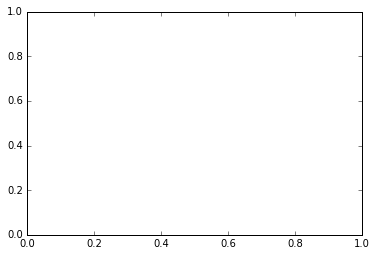

In [84]:
fig, ax = plt.subplots(1, 1)
methods, x = df.index.levels
for m in methods:
    y = df['50%'][m]
    lb = df['25%'][m]
    ub = df['75%'][m]
    ax.errorbar(x, y, yerr=np.array([lb, ub]), fmt='o-')
    ax.set_xscale("log", nonposx='clip', basex=2)
    ax.set_xlim(2**3, 2**9)
ax.set_xlabel('graph size')
ax.set_ylabel('query count')
ax.set_title('mean query count vs graph size on {} graphs'.format(gtype))
ax.legend(methods, loc='upper left')